In [ ]:
# ------------------ Load Necessary Libraries ------------------
# Install any missing packages using install.packages("packageName")
required_packages <- c("quantmod", "forecast", "tseries", "TSA",
                       "lmtest", "FinTS", "ggplot2", "lubridate",
                       "MASS", "car", "zoo")

installed_packages <- rownames(installed.packages())

for(p in required_packages){
  if(!(p %in% installed_packages)){
    install.packages(p, dependencies = TRUE)
  }
}

# Load Libraries
library(quantmod)      # For financial data retrieval
library(forecast)      # For time series forecasting
library(tseries)       # For statistical tests
library(TSA)           # For Extended ACF
library(lmtest)        # For diagnostic tests
library(FinTS)         # For ARCH tests
library(ggplot2)       # For enhanced plotting
library(lubridate)     # For date manipulation
library(MASS)          # For distribution fitting
# library(car)         # For advanced QQ plots
library(zoo)           # For handling regular and irregular time series data


# **1. Extraction des données**


## 1.1 Extraction et Choix du data set

- Nous avons travaillé sur les valeurs de prix de clôture de l'indice CAC40, téléchargées depuis le site `finance.yahoo.com`, pour la période allant du `1er janvier 2021` au `1er décembre 2023`.

- Cependant, les données fourni initialement était uniquement à partir du `1er janvier 2022`, ce qui n’était pas suffisant pour effectuer une décomposition `stl()` nécessaire à une prédiction plus efficace pour le modèle.

- De plus, nous n'avons pas pu extraire davantage de données pour la période antérieure en raison de l'impact du coronavirus (environ 2020), qui aurait probablement introduit un bruit négatif dans le modèle.

```
- On a choisi d'utiliser un dataset couvrant la période de 2021 à 2023, car le fichier `CAC40.csv` fourni ne contient des données que du `1er décembre 2022` au `1er décembre 2023`, ce qui est insuffisant pour notre analyse de prévision. De plus, nous avons opté pour l'exclusion des données antérieures à 2021, ainsi que celles couvrant la période de la pandémie de Covid-19, afin d'éviter d'introduire des biais dus aux événements exceptionnels de cette période.
```

- Par conséquent, nous avons choisi de commencer l'analyse à partir du `1er janvier 2021`.

- Étant donné que nous allons uniquement travailler avec les prix d'ouverture et de fermeture, nous avons extrait exclusivement ces deux colonnes pour l'analyse et la modélisation futures. Cela nous permet de simplifier les données et de nous concentrer sur les informations les plus pertinentes pour notre étude.

In [ ]:

# ------------------ 1. Data Acquisition ------------------

# Adjusted Start Date to 2021-01-01
start_date <- as.Date("2021-01-01")
end_date <- as.Date("2023-12-02")  # Forecasting up to Dec 1, 2023        1-1-2021          1-1-2022   -     1-12-2023

# Fetch CAC40 Data using quantmod
tryCatch({
  getSymbols("^FCHI", src = "yahoo", from = start_date, to = end_date, auto.assign = TRUE)
}, error = function(e) {
  stop("Error fetching data from Yahoo Finance: ", e)
})

# Extract Close Prices
if(!exists("FCHI")){
  stop("Symbol ^FCHI not found. Please check the data acquisition step.")
}

# Extract Open and Close Prices
cac40_open <- Op(FCHI)
cac40_close <- Cl(FCHI)

# Rename columns
colnames(cac40_open) <- "Open"
colnames(cac40_close) <- "Close"

# Convert to data frame
cac40_data <- data.frame(
  Date = index(cac40_close),
  Open = as.numeric(cac40_open),
  Close = as.numeric(cac40_close)
)



[1] "FCHI"

## 1.2 **Explication du code**

Le code ci-dessous montre comment nous avons acquis et préparé les données du CAC40 à partir de Yahoo Finance. Voici les étapes détaillées :

1. **Définition des dates de début et de fin :**
   - `start_date` est défini comme le 1er janvier 2021 et `end_date` comme le 2 décembre 2023, pour obtenir les prix des actions du CAC40 pendant cette période.

2. **Téléchargement des données du CAC40 :**
   - Le paquet `quantmod` est utilisé pour télécharger les données de l'indice CAC40 (symbole `^FCHI`) de Yahoo Finance, entre les dates spécifiées. Si une erreur se produit lors de la récupération des données, le code l'arrête avec un message d'erreur.

3. **Extraction des prix de clôture et d'ouverture :**
   - Nous extrayons uniquement les prix d'ouverture (`Op(FCHI)`) et de fermeture (`Cl(FCHI)`) de l'indice CAC40. Les autres colonnes ne sont pas nécessaires pour cette analyse, donc elles ne sont pas extraites.

4. **Renommage des colonnes :**
   - Nous avons renommé les colonnes extraites en "Open" et "Close" pour plus de clarté.

5. **Conversion en dataframe :**
   - Les données extraites sont converties en un dataframe avec les colonnes `Date`, `Open` et `Close`. Cela facilite le traitement des données pour les étapes suivantes de l'analyse et de la modélisation.


Cette approche nous permet d’acquérir et de préparer uniquement les données pertinentes pour l'analyse tout en prenant en compte les limitations des données fournies.


## 1.3 **Vue d'ensemble du jeu de données :**

Ce jeu de données contient les prix d'**ouverture** et de **clôture** de l'**indice CAC40** entre **janvier 2021** et **décembre 2023**. Le **CAC40** est un indice boursier de référence représentant les 40 plus grandes entreprises cotées à la bourse **Euronext Paris**. Ce jeu de données fournit des informations importantes sur les valeurs d'ouverture et de clôture de l'indice chaque jour, reflétant le sentiment du marché et les conditions économiques sur une période de près de trois ans.

### **Caractéristiques du jeu de données :**

Le jeu de données est structuré sous forme de **série chronologique** avec les colonnes suivantes :
<center>

| Date       | Open | Close |
|------------|------|-------|
| 2021-01-01 | 5750 | 5770  |
| 2021-01-02 | 5775 | 5800  |
| ...        | ...  | ...   |
| 2023-12-01 | 7400 | 7450  |

</center>

- **Date :** La date des données boursières, allant de **janvier 2021** à **décembre 2023**.
- **Prix d'ouverture (Open) :** Le prix auquel l'indice CAC40 a ouvert le jour donné.
- **Prix de clôture (Close) :** Le prix auquel l'indice CAC40 a clôturé le jour même.

In [ ]:
head(cac40_data)

,Date,Open,Close
,<date>,<dbl>,<dbl>
1,2021-01-04,5614.04,5588.96
2,2021-01-05,5561.60,5564.60
3,2021-01-06,5601.01,5630.60
4,2021-01-07,5651.04,5669.85
5,2021-01-08,5711.58,5706.88
6,2021-01-11,5684.66,5662.43


# **2. Data Cleaning et Verification**





## **2.1 Vérification des dimensions du dataset**

In [ ]:
# ------------------ 2. Data Cleaning and Verification ------------------

# 1. Check for dataset size and characteristics
cat("Dataset Dimensions: \n")
cat("Number of Rows:", nrow(cac40_data), "\n")
cat("Number of Columns:", ncol(cac40_data), "\n")

cat("\nColumn Names and Data Types:\n")
print(sapply(cac40_data, class))


Dataset Dimensions: 
Number of Rows: 752 
Number of Columns: 3 

Column Names and Data Types:
     Date      Open     Close 
   "Date" "numeric" "numeric" 


## 2.2. **Détection des valeurs manquantes**
   - **Objectif :** Identifier si des données essentielles sont manquantes.
   - **Méthodologie :**
     - Compter les valeurs manquantes dans les colonnes `Close` et `Open` avec `is.na()` et `sum()`.
   - **Importance :** Les valeurs manquantes peuvent entraîner des erreurs dans les analyses ou les modèles, nécessitant un nettoyage ou un traitement spécifique (par ex. imputation ou suppression).


In [ ]:
# 2. Check for missing values
num_na_close <- sum(is.na(cac40_data$Close))
num_na_open <- sum(is.na(cac40_data$Open))

if (num_na_close > 0 || num_na_open > 0) {
  cat("\nNumber of missing values detected:\n")
  cat("Close Prices:", num_na_close, "\n")
  cat("Open Prices:", num_na_open, "\n")
} else {
  cat("\nNo missing values detected in Open and Close prices.\n")
}



No missing values detected in Open and Close prices.



## 2.3. **Détection des outliers (valeurs aberrantes) :**
   - **Objectif :** Identifier les valeurs qui s'écartent considérablement des autres observations.
   - **Méthodologie :**
     - Utiliser la méthode IQR (Interquartile Range) :
       - Calcul des quartiles Q1 et Q3 avec `quantile()`.
       - Définir les bornes inférieure et supérieure comme `Q1 - 1.5*IQR` et `Q3 + 1.5*IQR`.
       - Compter les valeurs en dehors de ces bornes.
   - **Importance :** Les outliers peuvent biaiser les résultats des analyses statistiques ou des modèles prédictifs.



No outliers detected in Open and Close prices.


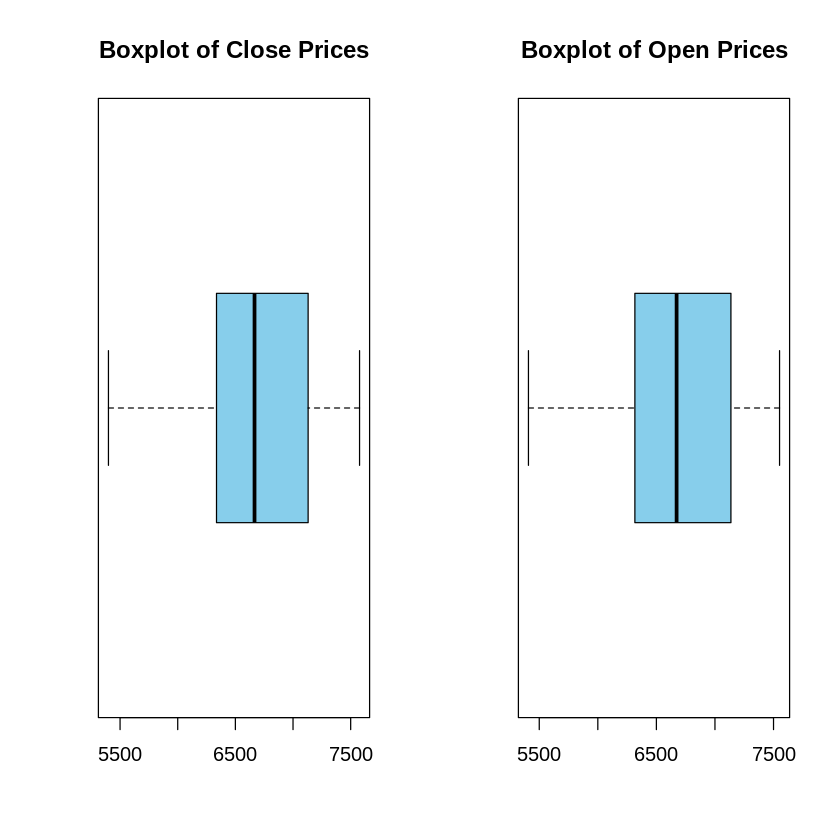

In [ ]:

# 3. Check for outliers (using the IQR method)
check_outliers <- function(column) {
  Q1 <- quantile(column, 0.25, na.rm = TRUE)
  Q3 <- quantile(column, 0.75, na.rm = TRUE)
  IQR <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR
  upper_bound <- Q3 + 1.5 * IQR
  sum(column < lower_bound | column > upper_bound, na.rm = TRUE)
}

num_outliers_close <- check_outliers(cac40_data$Close)
num_outliers_open <- check_outliers(cac40_data$Open)

if (num_outliers_close > 0 || num_outliers_open > 0) {
  cat("\nNumber of outliers detected:\n")
  cat("Close Prices:", num_outliers_close, "\n")
  cat("Open Prices:", num_outliers_open, "\n")
} else {
  cat("\nNo outliers detected in Open and Close prices.\n")
}

# Plot outliers for visualization
plot_outliers <- function(column, title) {
  boxplot(column, main = title, col = "skyblue", horizontal = TRUE)
}

par(mfrow = c(1, 2))
plot_outliers(cac40_data$Close, "Boxplot of Close Prices")
plot_outliers(cac40_data$Open, "Boxplot of Open Prices")
par(mfrow = c(1, 1))


## 2.4. **Vérification des doublons :**
   - **Objectif :** Identifier les lignes répétées.
   - **Méthodologie :**
     - Détecter les doublons avec `duplicated()` et les compter avec `sum()`.
   - **Importance :** Les doublons peuvent affecter la qualité des analyses en introduisant un biais.


In [ ]:

# 4. Check for duplicate rows
duplicate_rows <- sum(duplicated(cac40_data))
if (duplicate_rows > 0) {
  cat("\nNumber of duplicate rows detected:", duplicate_rows, "\n")
} else {
  cat("\nNo duplicate rows detected in the dataset.\n")
}



No duplicate rows detected in the dataset.



## 2.5. **Résumé de vérification complète :**
   - Fournir une vue d'ensemble de toutes les vérifications effectuées.





In [ ]:

# 5. Full Verification Summary
cat("\nFull Dataset Verification:\n")
cat("Dataset Dimensions - Rows:", nrow(cac40_data), "\n")
cat("Dataset Dimensions - Columns:", ncol(cac40_data), "\n")
cat("Missing Values - Close Prices:", num_na_close, "\n")
cat("Missing Values - Open Prices:", num_na_open, "\n")
cat("Outliers - Close Prices:", num_outliers_close, "\n")
cat("Outliers - Open Prices:", num_outliers_open, "\n")
cat("Duplicate Rows:", duplicate_rows, "\n")

cat("\nData cleaning verification completed.\n")


Full Dataset Verification:
Dataset Dimensions - Rows: 752 
Dataset Dimensions - Columns: 3 
Missing Values - Close Prices: 0 
Missing Values - Open Prices: 0 
Outliers - Close Prices: 0 
Outliers - Open Prices: 0 
Duplicate Rows: 0 

Data cleaning verification completed.


# **3. Les statistiques descriptives des prix d’ouverture et de fermeture et l'analyse de leur distribution**

## 3.1  **Les statistiques descriptives**

- **Méthodologie**

  - Pour analyser les données du CAC40, nous avons calculé des statistiques descriptives pour les prix d'ouverture et de clôture.

  - L'analyse a inclus des **mesures de tendance centrale (moyenne, médiane)**, de **dispersion (écart-type)** et de **forme de distribution (asymétrie, kurtosis)**.

  - Les calculs statistiques ont été réalisés à l'aide des fonctions R telles que `mean()`, `median()`, `sd()`, `min()`, `max()`, `skewness()` et `kurtosis()`.

  - Cela a permis d'obtenir une compréhension globale des caractéristiques du jeu de données. Les résultats ont été résumés dans un tableau structuré pour plus de clarté.

In [ ]:
# ------------------ 3. Descriptive Statistics and Distribution Analysis ------------------

# Calculate Descriptive Statistics
descriptive_stats <- data.frame(
  Statistic = c("Mean", "Median", "Std Dev", "Min", "Max", "Skewness", "Kurtosis"),
  Open = c(mean(cac40_data$Open), median(cac40_data$Open), sd(cac40_data$Open),
           min(cac40_data$Open), max(cac40_data$Open),
           skewness(cac40_data$Open), kurtosis(cac40_data$Open)),
  Close = c(mean(cac40_data$Close), median(cac40_data$Close), sd(cac40_data$Close),
            min(cac40_data$Close), max(cac40_data$Close),
            skewness(cac40_data$Close), kurtosis(cac40_data$Close))
)


# We can use summary ulternatively
# Using summary() for descriptive statistics

# summary_stats_open <- summary(cac40_data$Open)
# summary_stats_close <- summary(cac40_data$Close)

# # Display the results
# cat("Descriptive Statistics for Open Prices:\n")
# print(summary_stats_open)

# cat("\nDescriptive Statistics for Close Prices:\n")
# print(summary_stats_close) ar=p=3   d=1   ma=q
descriptive_stats

Statistic,Open,Close
<chr>,<dbl>,<dbl>
Mean,6676.2786222,6677.9466137
Median,6672.6000977,6666.1447754
Std Dev,510.5125489,509.0373572
Min,5407.7402344,5399.2099609
Max,7551.5000000,7577.0000000
Skewness,-0.3341132,-0.3268505
Kurtosis,-0.7971904,-0.7926393




**Résultats**  
L'analyse a révélé les insights suivants :

- **Tendance centrale** : Les moyennes des prix d'ouverture et de clôture étaient respectivement de 6676,28 et 6677,95, avec des médianes de 6672,60 et 6666,14. Cela indique que la distribution est relativement symétrique autour des valeurs centrales.

- **Dispersion** : Les écarts-types des prix d'ouverture et de clôture étaient respectivement de 510,51 et 509,03, montrant un niveau similaire de variabilité dans les deux colonnes.

- **Forme de distribution** : Les valeurs d'asymétrie pour les prix d'ouverture (-0,33) et de clôture (-0,33) suggèrent une légère asymétrie à gauche, ce qui signifie que les données ont une queue plus longue du côté inférieur. Les valeurs de kurtosis (-0,80 et -0,79) indiquent une distribution aplatie, avec moins de valeurs extrêmes par rapport à une distribution normale.

- **Plage** : Les prix ont varié de 5407,74 à 7551,50 pour l'ouverture et de 5399,21 à 7577,00 pour la clôture, mettant en évidence la variabilité au sein du jeu de données.

## 3.2 **L'analyse des distributions (Code)**

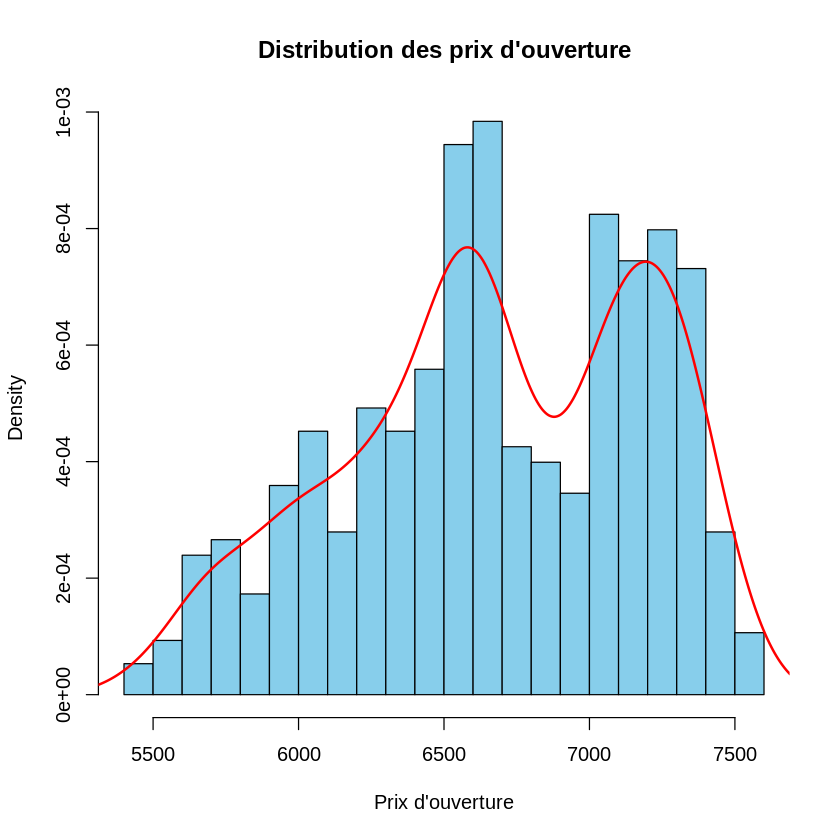

In [ ]:
# Histogram with density lines
hist(cac40_data$Open, breaks = 30, main = "Distribution des prix d'ouverture", col = "skyblue", xlab = "Prix d'ouverture", probability = TRUE)

# Add density lines
lines(density(cac40_data$Open), col = "red", lwd = 2)


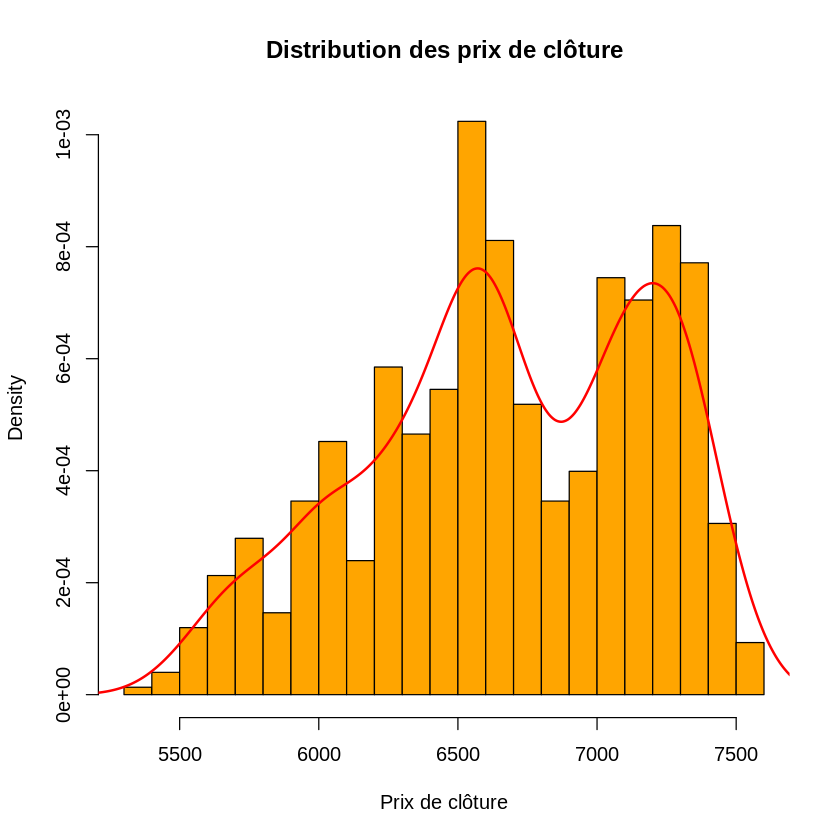

In [ ]:
# Histogram with density lines for Close prices
hist(cac40_data$Close, breaks = 30, main = "Distribution des prix de clôture", col = "orange", xlab = "Prix de clôture", probability = TRUE)

# Add density lines
lines(density(cac40_data$Close), col = "red", lwd = 2)


## **3.3 Resultats: Analyse des distributions des prix d'ouverture et de clôture de l'indice CAC40 (2021-2023) - Resultats et discussions**

### 1. Distribution des prix d'ouverture

- **Forme de la distribution :** La distribution des prix d'ouverture présente une structure bimodale, avec deux pics principaux autour de 6200 et 7000 points. Cela reflète des périodes distinctes de performance du marché.

- **Tendance centrale :**

  - Moyenne : 6676,28
  - Médiane : 6672,60

Ces valeurs proches indiquent une distribution relativement symétrique autour de la moyenne.


- **Dispersion :**

    - Écart-type : 510,51, ce qui montre une variation modérée des prix d'ouverture.


- **Asymétrie et aplatissement :**

  - Asymétrie (Skewness) : -0,33, indiquant une légère asymétrie vers la gauche (valeurs plus faibles).
  - Aplatissement (Kurtosis) : -0,79, suggérant une distribution légèrement plus plate que la normale.



### 2. Distribution des prix de clôture

- **Forme de la distribution :** La distribution des prix de clôture est également bimodale, avec des pics similaires à ceux des prix d'ouverture, mais légèrement décalés.
- **Tendance centrale :**

  - Moyenne : 6677,95
  - Médiane : 6666,14
Les prix de clôture sont en moyenne légèrement supérieurs aux prix d'ouverture, ce qui reflète une tendance haussière intra-journalière.


- **Dispersion :**

  - Écart-type : 509,04, très proche de celui des prix d'ouverture, indiquant une volatilité similaire.


- **Asymétrie et aplatissement :**

  - Asymétrie (Skewness) : -0,33, similaire à celle des prix d'ouverture.
  - Aplatissement (Kurtosis) : -0,79, également comparable à celui des prix d'ouverture.



### 3. Comparaison des distributions

Les distributions des prix d'ouverture et de clôture sont très similaires en termes de forme, de tendance centrale et de dispersion.
Les prix de clôture sont légèrement plus élevés que les prix d'ouverture, ce qui reflète une tendance haussière générale sur la période analysée.


### 5. Conclusion

L'indice CAC40 a connu une croissance soutenue sur la période, avec des prix d'ouverture et de clôture suivant des tendances similaires.
Les distributions bimodales reflètent des périodes distinctes de performance du marché, influencées par des facteurs économiques et géopolitiques.
La légère asymétrie et l'aplatissement des distributions indiquent une stabilité relative, malgré des fluctuations importantes lors d'événements majeurs.

## 3.4 **Graphique les prix d'ouverture et de clôture (Data Visualization)**

- Le graphique  affichera deux lignes : une pour les prix "Open" en bleu et une pour les prix "Close" en rouge, toutes deux tracées sur la période de 2021 à décembre 2023.

- Ce graphique permet de visualiser l'évolution des prix et de comparer les tendances des prix d'ouverture et de clôture au fil du temps.

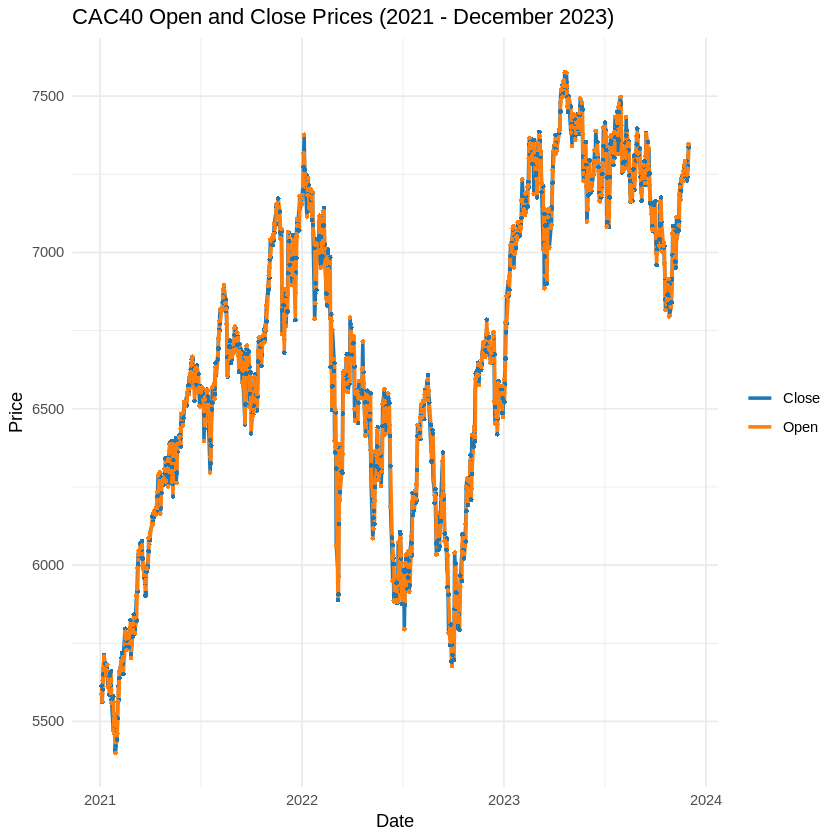

In [ ]:
# Create a data frame for plotting both Open and Close prices
plot_data <- data.frame(
  Date = as.Date(cac40_data$Date),  # Ensure Date is in Date format
  Open = as.numeric(cac40_data$Open),
  Close = as.numeric(cac40_data$Close)
)

# Reshape the data for ggplot
library(tidyr)
plot_data_long <- plot_data %>%
  pivot_longer(cols = c(Open, Close), names_to = "Price_Type", values_to = "Price")

# Plot Open and Close prices on the same graph with softer, clear colors and dots showing differences
ggplot(plot_data_long, aes(x = Date, y = Price, color = Price_Type)) +
  geom_line(size = 1) +  # Lines for Open and Close prices
  geom_point(data = plot_data, aes(x = Date, y = Open), color = "#1F77B4", size = 1, shape = 16) +  # Dots for Open prices
  geom_point(data = plot_data, aes(x = Date, y = Close), color = "#FF7F0E", size = 1, shape = 16) +  # Dots for Close prices
  ggtitle("CAC40 Open and Close Prices (2021 - December 2023)") +
  xlab("Date") + ylab("Price") +
  theme_minimal() +
  scale_color_manual(values = c("#1F77B4", "#FF7F0E")) +  # Soft blue and soft orange
  theme(legend.title = element_blank())




### **Analyse des graphiques**

1. **Tendance générale :**
   L'indice **CAC40** montre une **croissance soutenue** sur la période, avec une tendance haussière globale. Le marché semble réagir positivement à des événements favorables comme la reprise économique post-COVID-19 et l'optimisme lié à l'évolution économique en Europe.

2. **Volatilité marquée :**
   On observe une **volatilité élevée** durant certains événements majeurs comme la **guerre en Ukraine** (2022), ce qui provoque de fortes fluctuations entre les prix d'ouverture et de clôture. Les périodes de baisse, en particulier en 2022, montrent des écarts notables entre les deux prix, ce qui pourrait refléter l'incertitude et la panique des investisseurs face aux conditions géopolitiques.

3. **Proximité des prix d'ouverture et de clôture :**
   Bien que les **prix d'ouverture** et **de clôture** soient généralement proches, des divergences apparaissent parfois, surtout lorsque des nouvelles importantes influencent les marchés pendant la journée. En règle générale, les prix de clôture sont légèrement plus élevés que les prix d'ouverture, suggérant une tendance haussière en fin de journée.

4. **Fluctuations internes :**
   Des périodes plus marquées de **fortes variations** se produisent, souvent en fin de mois ou au début de certaines périodes de reporting financier. Cela indique que les **mouvements intra-journaliers** jouent un rôle important dans les ajustements de marché.

### **Conclusion :**
L'analyse de la courbe du CAC40 entre **2021 et 2023** révèle une **croissance soutenue** globalement, malgré une **volatilité notable** en raison de crises géopolitiques et économiques. Les prix d'ouverture et de clôture suivent des tendances similaires, mais les écarts entre les deux peuvent suggérer des ajustements importants du marché face à des informations critiques.



In [ ]:
# ------------------ 4. Log Transformation (Not necessery)------------------

log_cac40_close <- cac40_close


# 4. **Transformation des données**


Nous avons stocké les données dans un objet série temporelle, ce qui nous permet d'utiliser les nombreuses fonctions de R pour analyser les données temporelles. Nous utilisons la fonction ts() de R pour cela.
Étant donné que notre série temporelle a été collectée à intervalles réguliers, nous spécifions le nombre de fois que les données ont été collectées par an en utilisant le paramètre frequency dans la fonction ts(). Nous fixons frequency = 252 car nous avons en moyenne 252 données collectées par an, ce qui correspond approximativement au nombre de jours de trading sur le marché boursier chaque année.

In [ ]:
# ------------------ 5. Convert to 'ts' Object with Correct Frequency ------------------

# Convert to numeric vector
log_cac40_vector <- as.numeric(log_cac40_close)

# Create time series object with frequency = 252 (approximate trading days per year)
log_cac40_ts <- ts(log_cac40_vector, frequency = 252)

In [ ]:
# ------------------ 10. Stationarity Check ------------------

# Perform Augmented Dickey-Fuller Test on the random component
adf_test_result <- adf.test(log_cac40_close, alternative = "stationary")
cat("\nAugmented Dickey-Fuller Test on Random Part:\n")
print(adf_test_result)

# If the series is not stationary, consider differencing
if(adf_test_result$p.value > 0.05){
  log_cac40_close_stationary <- diff(log_cac40_close, differences = 1)
  # Remove NA resulting from differencing
  log_cac40_close_stationary <- na.omit(log_cac40_close_stationary)
  cat("Differenced the random part to achieve stationarity.\n")
  stationary_used <- TRUE
} else {
  log_cac40_close_stationary <- log_cac40_close
  cat("The random part is stationary. Proceeding without differencing.\n")
  stationary_used <- FALSE
}


Augmented Dickey-Fuller Test on Random Part:

	Augmented Dickey-Fuller Test

data:  log_cac40_close
Dickey-Fuller = -2.5487, Lag order = 9, p-value = 0.346
alternative hypothesis: stationary

Differenced the random part to achieve stationarity.


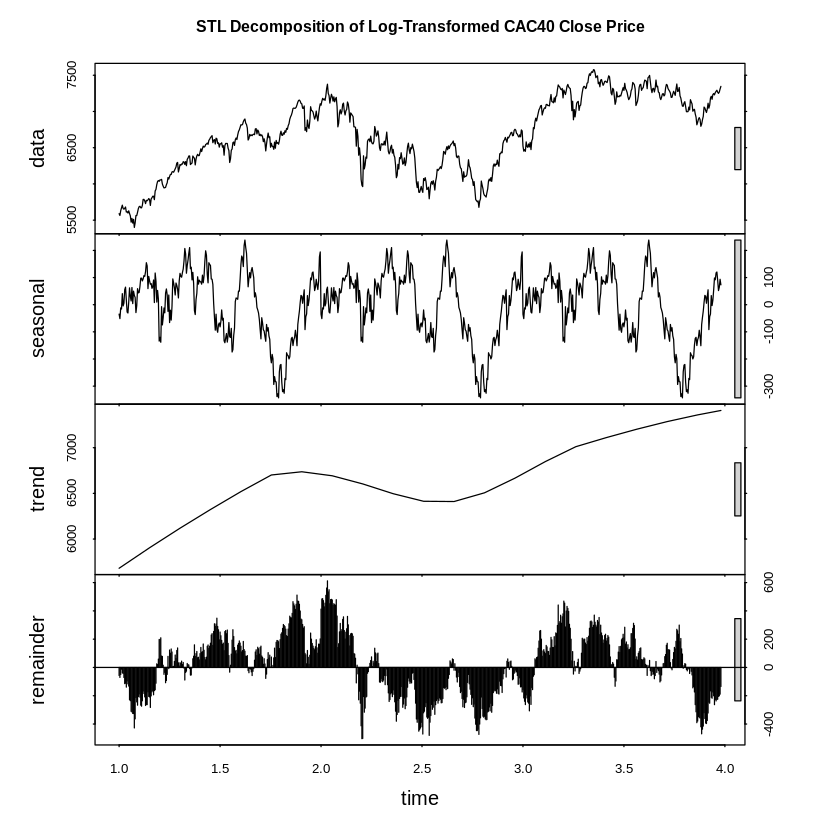

In [ ]:
# ------------------ 6. STL Decomposition ------------------

# Perform STL Decomposition
stl_decomp <- stl(log_cac40_ts, s.window = "periodic")

# Plot STL decomposition
plot(stl_decomp, main = "STL Decomposition of Log-Transformed CAC40 Close Price")

In [ ]:
# ------------------ 7. Extract Components ------------------

seasonal_component <- stl_decomp$time.series[, "seasonal"]
trend_component <- stl_decomp$time.series[, "trend"]
remainder_component <- stl_decomp$time.series[, "remainder"]



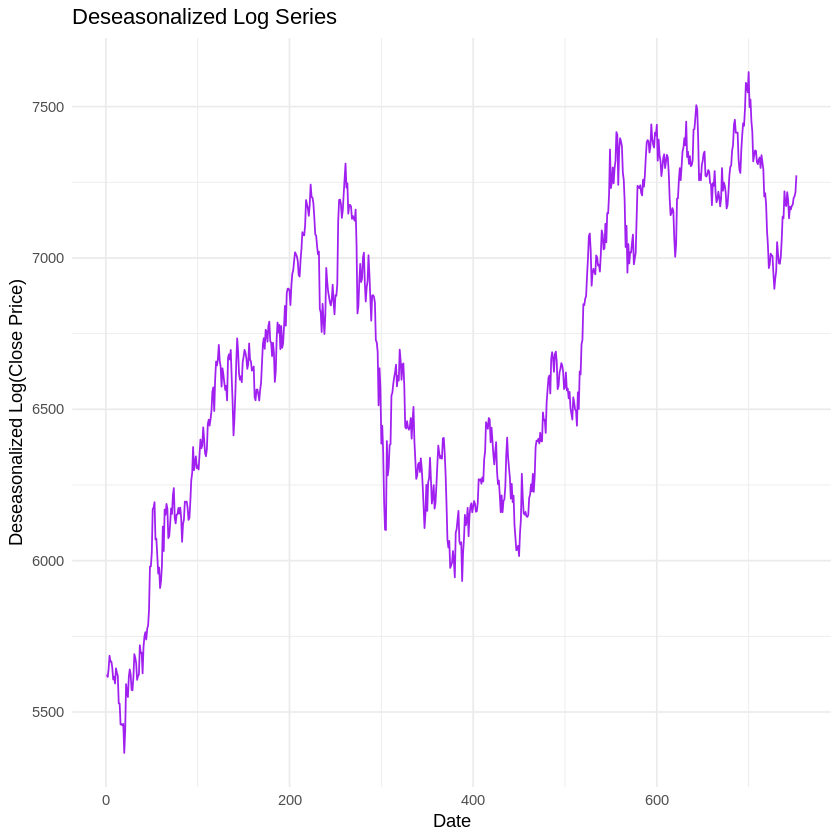

In [ ]:
# ------------------ 8. Plot Deseasonalized Series ------------------

# Deseasonalize by removing the seasonal component
deseasonalized <- log_cac40_ts - seasonal_component

# Create a data frame for plotting
deseasonalized_df <- data.frame(
  Date = index(cac40_data$Close),
  Deseasonalized = as.numeric(deseasonalized)
)

# Plot Deseasonalized Series
ggplot(deseasonalized_df, aes(x = Date, y = Deseasonalized)) +
  geom_line(color = "purple") +
  ggtitle("Deseasonalized Log Series") +
  xlab("Date") + ylab("Deseasonalized Log(Close Price)") +
  theme_minimal()



In [ ]:
# ------------------ 9. Remove Trend to Get Random Component ------------------

# Remove trend to isolate the random component
random_part <- deseasonalized - trend_component

# Verify random_part is a single numeric vector
if(length(random_part) != length(log_cac40_ts)){
  stop("Random part length mismatch.")
}


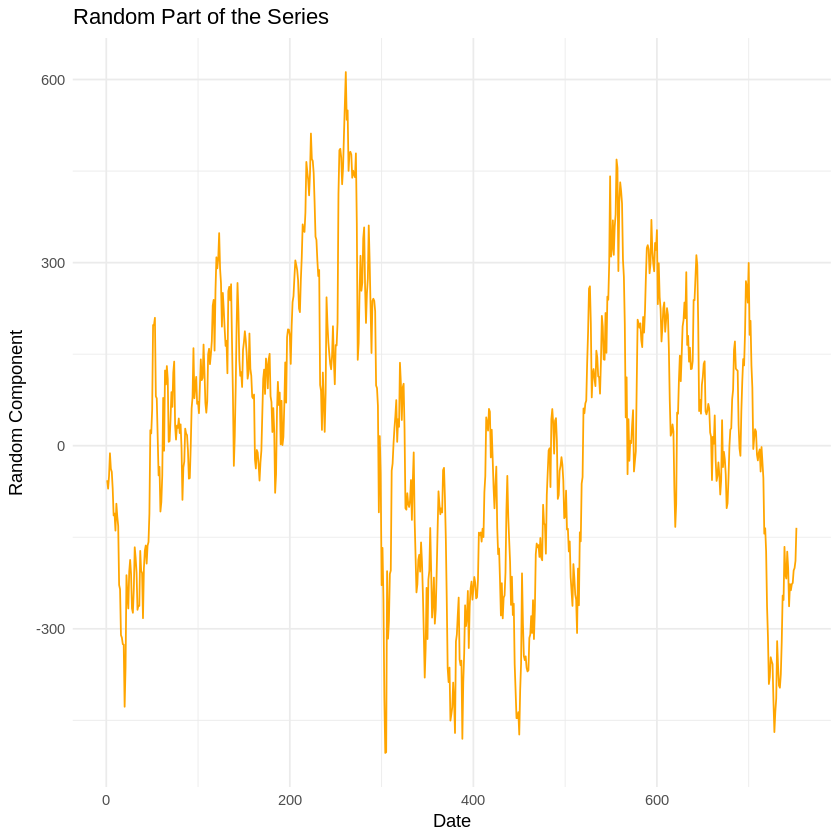

In [ ]:

# Create a data frame for plotting
random_part_df <- data.frame(
  Date = index(cac40_data$Close),
  Random = as.numeric(random_part)
)

# Plot Random Part
ggplot(random_part_df, aes(x = Date, y = Random)) +
  geom_line(color = "orange") +
  ggtitle("Random Part of the Series") +
  xlab("Date") + ylab("Random Component") +
  theme_minimal()



In [ ]:
# # ------------------ 10. Stationarity Check ------------------

# # Perform Augmented Dickey-Fuller Test on the random component
# adf_test_result <- adf.test(random_part, alternative = "stationary")
# cat("\nAugmented Dickey-Fuller Test on Random Part:\n")
# print(adf_test_result)

# # If the series is not stationary, consider differencing
# if(adf_test_result$p.value > 0.05){
#   random_part_stationary <- diff(random_part, differences = 1)
#   # Remove NA resulting from differencing
#   random_part_stationary <- na.omit(random_part_stationary)
#   cat("Differenced the random part to achieve stationarity.\n")
#   stationary_used <- TRUE
# } else {
#   random_part_stationary <- random_part
#   cat("The random part is stationary. Proceeding without differencing.\n")
#   stationary_used <- FALSE
# }



###6. Modele ARIMA





In [ ]:
# ------------------ 12. ARMA Model Identification and Fitting ------------------

# 12.1 Automatic ARIMA Modeling (`auto.arima()`)
library(forecast)
arma_auto <- auto.arima(random_part, seasonal = FALSE, stepwise = FALSE, approximation = FALSE, trace = FALSE)
cat("\nAuto ARIMA Model:\n")
print(arma_auto)

# 12.2 Using Extended Autocorrelation Function (EACF)
library(TSA)
eacf_result <- eacf(as.ts(random_part))
cat("\nExtended ACF (EACF) Result:\n")
print(eacf_result)

# 12.3 Modified Information Criteria (AIC & BIC) Grid Search
compute_aic_bic <- function(ts_data, max_p = 5, max_q = 5) {
  aic_matrix <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1,
                       dimnames = list(p = 0:max_p, q = 0:max_q))
  bic_matrix <- matrix(NA, nrow = max_p + 1, ncol = max_q + 1,
                       dimnames = list(p = 0:max_p, q = 0:max_q))

  for(p in 0:max_p){
    for(q in 0:max_q){
      # Skip (0,0) model
      if(p == 0 && q ==0){
        next
      }
      tryCatch({
        model <- arima(ts_data, order = c(p, 0, q), method = "ML", include.mean = FALSE)
        aic_matrix[p + 1, q + 1] <- AIC(model)
        bic_matrix[p + 1, q + 1] <- BIC(model)
      }, error = function(e){
        message(sprintf("Error fitting ARIMA(%d,0,%d): %s", p, q, e$message))
      })
    }
  }
  list(AIC = aic_matrix, BIC = bic_matrix)
}



# Use random_part if stationary
adf_test_original <- adf.test(random_part)
print(adf_test_original)
criteria <- compute_aic_bic(random_part, max_p = 5, max_q = 5)

# Display AIC and BIC matrices
library(knitr)
cat("\nAIC Values:\n")
kable(criteria$AIC, digits = 2)

cat("\nBIC Values:\n")
kable(criteria$BIC, digits = 2)

# Modified find_best_model function
find_best_model <- function(criteria_matrix) {
  min_value <- min(criteria_matrix, na.rm = TRUE)
  if (is.infinite(min_value) || is.na(min_value)) {
    stop("No valid models were found. All AIC/BIC values are NA or Inf.")
  }
  indices <- which(criteria_matrix == min_value, arr.ind = TRUE)
  if (nrow(indices) == 0) {
    stop("No indices found matching the minimum AIC/BIC value.")
  }
  best_p <- as.numeric(rownames(criteria_matrix)[indices[1, "p"]])
  best_q <- as.numeric(colnames(criteria_matrix)[indices[1, "q"]])
  list(p = best_p, q = best_q, value = min_value)
}

# Find best models
best_aic <- find_best_model(criteria$AIC)
best_bic <- find_best_model(criteria$BIC)

cat(sprintf("\nBest Model According to AIC: ARIMA(%d,0,%d) with AIC = %.2f\n",
            best_aic$p, best_aic$q, best_aic$value))
cat(sprintf("Best Model According to BIC: ARIMA(%d,0,%d) with BIC = %.2f\n",
            best_bic$p, best_bic$q, best_bic$value))

# Fit the best models
best_model_aic <- arima(random_part, order = c(best_aic$p, 0, best_aic$q), method = "ML", include.mean = FALSE)
best_model_bic <- arima(random_part, order = c(best_bic$p, 0, best_bic$q), method = "ML", include.mean = FALSE)

cat("\nSummary of Best Model According to AIC:\n")
print(best_model_aic)

cat("\nSummary of Best Model According to BIC:\n")
print(best_model_bic)


Auto ARIMA Model:
Series: random_part 
ARIMA(0,1,0) 

sigma^2 = 3323:  log likelihood = -4110.43
AIC=8222.86   AICc=8222.86   BIC=8227.48
AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x x x x x x x x x x  x  x  x 
1 o o o o o o o x o o o  o  o  o 
2 x o o o o o o x o o o  o  o  o 
3 x o o o o o o x o o o  o  o  o 
4 x x x o o o o x o o o  o  o  o 
5 x x x x o o o o o o o  o  o  o 
6 x x x x x o o o o o o  o  o  o 
7 x x x x x o o o o o o  o  o  o 

Extended ACF (EACF) Result:
$eacf
             [,1]          [,2]         [,3]         [,4]         [,5]
[1,]  0.966007144  0.9332340987  0.900822217  0.871620583  0.842090682
[2,] -0.005077231  0.0111196744 -0.032330635  0.017468390  0.058725427
[3,]  0.377859341 -0.0003227621 -0.020514636  0.010443675  0.046723177
[4,]  0.307941562 -0.0381099586 -0.003198873  0.007410479  0.032024346
[5,]  0.413525795  0.2640338639  0.121971217  0.006517302  0.009101571
[6,] -0.264280101  0.4046997584 -0.272560525  0.219457867  0.014294337
[7,]  0.477798408

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”
Warning message in log(s2):
“NaNs produced”
Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible convergence problem: optim gave code = 1”
Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
“possible conv


AIC Values:




|   |       0|       1|       2|       3|       4|       5|
|:--|-------:|-------:|-------:|-------:|-------:|-------:|
|0  |      NA| 9492.32| 9050.30| 8764.67| 8653.56| 8531.32|
|1  | 8235.80| 8227.01| 8229.64| 8230.28| 8241.60| 8236.99|
|2  | 8227.01| 8228.81| 8249.49| 8242.07| 8235.85| 8236.32|
|3  | 8228.93| 8230.77| 8221.63| 8243.17| 8244.19| 8227.45|
|4  | 8230.20| 8232.16| 8234.74| 8225.50| 8236.08| 8236.06|
|5  | 8231.99| 8234.07| 8235.48| 8226.94| 8229.00| 8230.72|


BIC Values:




|   |       0|       1|       2|       3|       4|       5|
|:--|-------:|-------:|-------:|-------:|-------:|-------:|
|0  |      NA| 9501.56| 9064.17| 8783.17| 8676.68| 8559.05|
|1  | 8245.05| 8240.88| 8248.13| 8253.39| 8269.34| 8269.35|
|2  | 8240.88| 8247.30| 8272.60| 8269.81| 8268.21| 8273.31|
|3  | 8247.42| 8253.88| 8249.36| 8275.53| 8281.18| 8269.05|
|4  | 8253.31| 8259.89| 8267.10| 8262.48| 8277.69| 8282.29|
|5  | 8259.73| 8266.42| 8272.46| 8268.55| 8275.23| 8281.57|


Best Model According to AIC: ARIMA(3,0,2) with AIC = 8221.63
Best Model According to BIC: ARIMA(2,0,0) with BIC = 8240.88

Summary of Best Model According to AIC:

Call:
arima(x = random_part, order = c(best_aic$p, 0, best_aic$q), include.mean = FALSE, 
    method = "ML")

Coefficients:
          ar1     ar2     ar3     ma1     ma2
      -0.0913  0.1032  0.8845  1.0569  0.9582
s.e.   0.0337  0.0404  0.0426  0.0240  0.0330

sigma^2 estimated as 3214:  log likelihood = -4104.81,  aic = 8219.63

Summary of Best Model According to BIC:

Call:
arima(x = random_part, order = c(best_bic$p, 0, best_bic$q), include.mean = FALSE, 
    method = "ML")

Coefficients:
         ar1     ar2
      0.9607  0.0050
s.e.  0.0364  0.0365

sigma^2 estimated as 3264:  log likelihood = -4110.51,  aic = 8225.01


# **7. Division des données et évaluation des performances**

## 7.1 Division des donnée
Divisez les données temporelles en deux parties :
* Ensemble d’apprentissage (ou training set) : Utilisé pour ajuster le modèle ARIMA. Ce sont les données historiques sur lesquelles le modèle apprend.

* Ensemble de test (ou testing set) : Utilisé pour évaluer la performance du modèle. Il s'agit d'une portion de données situées chronologiquement après l’ensemble d’apprentissage.



### 7.1.1 Définir la date de séparation
split_date : Spécifie la date qui sépare les données en deux groupes :
* Données jusqu'à cette date inclusivement pour l'entraînement.
* Données après cette date pour le test.

In [ ]:
# ------------------ 1. Définir la date de séparation ------------------
# Cette date détermine la fin de l'ensemble d'entraînement.
split_date <- as.Date("2022-12-31")

# Récupérer les indices de temps (dates) associés aux données de la série temporelle.
dates_all <- index(cac40_close)  # Récupère les indices des données (supposé être des dates).
dates_all <- as.Date(dates_all)  # Convertit ces indices au format Date.


### 7.1.2 Gestion des données différenciées
* **Stationnarité** :
Si les données ont été différenciées pour les rendre stationnaires, les dates doivent être ajustées (car la différenciation réduit la taille des données en supprimant les premières valeurs).

* **Indices d'entraînement et de test** :
Les indices dépendent de la date de séparation et des données utilisées (stationnarisées ou non).

* **random_part_stationary_full** :
Contient la série aléatoire ajustée selon que les données soient stationnarisées ou non.

In [ ]:
# ------------------ 2. Gestion des données différenciées ------------------

if(stationary_used){
  # Adjust indices due to differencing
  dates_stationary <- dates_all[-1]  # dates adjusted for differenced data
  train_indices <- dates_stationary <= split_date
  test_indices <- dates_stationary > split_date
  random_part_stationary_full <- random_part_stationary
} else {
  train_indices <- dates_all <= split_date
  test_indices <- dates_all > split_date
  random_part_stationary_full <- random_part_stationary
}





### 7.1.3 Préparation des données
- **Division en sous-composantes :**
 - La série temporelle décomposée (aléatoire, tendance, saisonnalité) est divisée en ensembles d'entraînement et de test.
Chaque composante est indexée selon les dates (indices d'entraînement et de test).
- **Cette division permet d'analyser séparément chaque composante.**

In [ ]:
# ------------------ 3. Préparation des données ------------------
# Division de la composante aléatoire
random_train <- random_part_stationary_full[train_indices]  # Ensemble d'entraînement (aléatoire).
random_test <- random_part_stationary_full[test_indices]    # Ensemble de test (aléatoire).

# Division de la composante de tendance
trend_train <- trend_component[train_indices]  # Ensemble d'entraînement (tendance).
trend_test <- trend_component[test_indices]    # Ensemble de test (tendance).

# Division de la composante saisonnière
seasonal_train <- seasonal_component[train_indices]  # Ensemble d'entraînement (saisonnalité).
seasonal_test <- seasonal_component[test_indices]    # Ensemble de test (saisonnalité).


### 7.1.4 Conversion de l'ensemble d'entraînement en série temporelle

- **Conversion en objet ts :**
 - La composante aléatoire d'entraînement est transformée en une série temporelle (ts) pour être utilisée avec des modèles ou méthodes dédiés (comme ARIMA, STL, etc.).
- **Fréquence :**
 - La fréquence est récupérée automatiquement depuis les données source (par exemple, 365 pour une série journalière).

In [ ]:
# ------------------ 4. Conversion de l'ensemble d'entraînement en série temporelle ------------------
# Conversion de la composante aléatoire d'entraînement en un objet série temporelle.
random_train_ts <- ts(random_train, frequency = frequency(random_part_stationary))



### 7.1.5 Définir l'horizon de prévision
- **Horizon de prévision :**
 - La longueur de l'ensemble de test détermine le nombre de pas à prédire.

 - Cela garantit une comparaison directe entre les prévisions et les données réelles sur la même période.


In [ ]:
# ------------------ 5. Définir l'horizon de prévision ------------------
# L'horizon de prévision est égal à la taille de l'ensemble de test.
h_forecast <- length(random_test)


ERROR: Error: object 'random_test' not found


# **8. Prévisions sur les prix futurs**

## 8.1 Préparation des Modèles et Prévisions Initiales

### 8.1.1 Extraire les paramètres du modèle ARIMA :
- model_order est un vecteur qui contient les paramètres du modèle ARIMA :𝑝,𝑑 et 𝑞.

- Ces valeurs sont extraites et assignées aux variables model_p, model_d, et model_q.

In [ ]:
forecast_and_collect <- function(model_order, model_name) {
  # Extract model parameters
  model_p <- model_order[1]
  model_d <- model_order[2]
  model_q <- model_order[3]
}

### 8.1.2 Vérification de la différenciation :
- Si 𝑑>0 cela signifie que la série a été différenciée pour la rendre stationnaire. La différenciation peut réduire l'horizon de prévision. Nous devons ajuster h_forecast_model pour prendre cela en compte.
 - Différenciation : Si 𝑑>0 la fonction diff() est utilisée pour différencier les données.
 - Ajustement de l'horizon de prévision : L'horizon de prévision (h_forecast_model) est ajusté pour compenser la réduction de la série due à la différenciation.
 - Si l'horizon devient négatif ou nul, une erreur est générée.

In [ ]:

  # Check if differencing is needed for this model
  if(model_d > 0){
    # Difference the data for this model
    random_train_used <- diff(random_train_ts, differences = model_d)
    # Adjust h_forecast if necessary
    h_forecast_model <- h_forecast - model_d
    if(h_forecast_model <= 0){
      stop("Forecast horizon is too short after differencing.")
    }
  } else {
    random_train_used <- random_train_ts
    h_forecast_model <- h_forecast
  }

### 8.1.3 Ajustement du modèle ARIMA :
- Nous ajustons le modèle ARIMA en fonction des données différenciées (ou non) avec les paramètres 𝑝 et 𝑞.

- Arima() : Cette fonction ajuste un modèle ARIMA sur les données.
  - Le paramètre order spécifie les valeurs de
𝑝, 𝑑 et q.
  
  - include.mean = FALSE indique que nous n'incluons pas de constante (terme moyen) dans le modèle ARIMA.



In [ ]:
# Fit the ARIMA model to the appropriate data
  model <- Arima(random_train_used, order = c(model_p, 0, model_q), include.mean = FALSE)

### 8.1.4 Prévision de la composante aléatoire

 Une fois le modèle ajusté, nous effectuons des prévisions sur la composante aléatoire, et si une différenciation a été appliquée, nous devons inverser cette transformation.

- **Prévision :** La fonction **forecast()** génère des prévisions sur la composante aléatoire pour la période spécifiée par h_forecast_model.

- **Inversion de la différenciation :** Si une différenciation a été appliquée, la fonction **diffinv()** est utilisée pour inverser la différenciation. Ensuite, les premières valeurs sont supprimées pour éviter d'inclure des données erronées.

- **Ajustement de l'horizon de prévision :** Après inversion de la différenciation, l'horizon de prévision est ajusté en fonction de la longueur de la série prévisionnelle, pour garantir que la taille de l'horizon est correcte.

In [ ]:
# Forecast the random component
  forecast_random <- forecast(model, h = h_forecast_model)
  forecast_random_values <- as.numeric(forecast_random$mean)

  # Invert differencing if needed
  if(model_d > 0){
    # Use last observed values from training data for inversion
    last_values <- tail(random_train_ts, n = model_d)
    forecast_random_values <- diffinv(forecast_random_values, xi = last_values)
    # Remove first 'model_d' values which are initial values
    forecast_random_values <- forecast_random_values[-seq_len(model_d)]
  }
    # Adjust forecast horizon if differencing reduced it
  forecast_horizon <- length(forecast_random_values)

### 8.1.5 Prévision de la tendance et de la saisonnalité :
Une fois que la composante aléatoire est prévisionnée, nous prévoyons les composantes de tendance et de saisonnalité. La tendance est extrapolée à partir de la dernière valeur observée, et la saisonnalité est répétée selon le motif saisonnier.

- **Prévision de la tendance :** Nous extrapolons la dernière valeur de la tendance observée (last_trend_train_value) et la répétons pour toute la période de prévision (forecast_horizon).

- **Prévision de la saisonnalité :** Nous utilisons la dernière période saisonnière (en fonction de seasonal_period) et la répétons pour la période de prévision. Si la saisonnalité n'est pas présente, la saisonnalité est fixée à zéro.



In [ ]:
 # Forecast trend component (extend the trend)
  last_trend_train_value <- tail(trend_train, n = 1)
  forecast_trend <- rep(last_trend_train_value, forecast_horizon)

  # Forecast seasonal component (repeat the seasonal pattern)
  seasonal_period <- frequency(stl_decomp$time.series)
  if (seasonal_period > 1) {
    last_seasonal_values <- tail(seasonal_component, seasonal_period)
    forecast_seasonal <- rep(last_seasonal_values, length.out = forecast_horizon)
  } else {
    forecast_seasonal <- rep(0, forecast_horizon)
  }

### 8.1.6 Reconstruire la série prévisionnelle complète :
La série prévisionnelle complète est obtenue en combinant les prévisions des composantes aléatoire, tendance et saisonnalité.
- La série prévisionnelle complète est reconstruite en additionnant les prévisions des composantes aléatoire, tendance et saisonnalité. Cela donne la prévision totale de la série.

In [ ]:
 # Reconstruct the forecasted series
  forecast_linear <- forecast_random_values + forecast_trend + forecast_seasonal

### 8.1.7 Calcul des métriques de précision
Les métriques de précision (MAE, MSE, RMSE) sont calculées pour évaluer la performance du modèle de prévision.
- MAE (Mean Absolute Error) : Mesure l’erreur absolue moyenne.
- MSE (Mean Squared Error) : Mesure l'erreur quadratique moyenne.
- RMSE (Root Mean Squared Error) : Mesure l'erreur quadratique moyenne mais avec une échelle plus intuitive.

In [ ]:
 # Actual values
  actual_values <- as.numeric(cac40_close[test_indices])
  actual_values <- actual_values[seq_len(forecast_horizon)]

  # Dates
  forecast_dates <- dates_all[test_indices][seq_len(forecast_horizon)]

  # Calculate forecast accuracy metrics
  mae <- mean(abs(forecast_linear - actual_values), na.rm = TRUE)
  mse <- mean((forecast_linear - actual_values)^2, na.rm = TRUE)
  rmse <- sqrt(mse)

  cat("\nForecast Accuracy Metrics for", model_name, ":\n")
  cat("MAE:", round(mae, 4), "\n")
  cat("MSE:", round(mse, 4), "\n")
  cat("RMSE:", round(rmse, 4), "\n")

### 8.1.8 Retourner les résultats
La fonction retourne les métriques de précision, le data frame des prévisions et le modèle ajusté pour une analyse et un suivi ultérieurs.
- Data frame des prévisions : Un tableau est créé pour afficher les prévisions, les valeurs réelles et le modèle utilisé.
- La fonction retourne ces résultats pour une analyse ultérieure.


In [ ]:

  # Create a data frame for plotting
  forecast_df <- data.frame(
    Date = forecast_dates,
    Forecast = forecast_linear,
    Actual = actual_values,
    Model = model_name
  )

  # Return the accuracy metrics, forecast data frame, and model
  return(list(MAE = mae, MSE = mse, RMSE = rmse, forecast_df = forecast_df, model = model))

ERROR: Error: object 'forecast_dates' not found


## 8.2.1 Analyse des Résultats et Évaluation des Modèles ARIMA
Utiliser différentes configurations de modèles ARIMA pour effectuer des prévisions et collecter les résultats pour chaque modèle. Cela permet de comparer les performances de plusieurs modèles ARIMA sur les mêmes données.

- Nous utilisons la fonction forecast_and_collect() pour effectuer des prévisions pour trois modèles ARIMA différents :
 - ARIMA(3,0,2) : un modèle avec 3 termes autorégressifs et 2 termes de moyenne mobile.
 - ARIMA(2,0,0) : un modèle avec 2 termes autorégressifs.
 - ARIMA(0,1,0) : un modèle avec une différenciation ( 𝑑=1 ) mais sans termes autorégressifs ni moyenne mobile.
- Chaque appel à forecast_and_collect() génère les prévisions et les métriques de précision (MAE, MSE, RMSE) pour chaque modèle.

In [ ]:
# Forecast and collect results for ARIMA(3,0,2)
results_arima_3_0_2 <- forecast_and_collect(c(3, 0, 2), "ARIMA(3,0,2)")

# Forecast and collect results for ARIMA(2,0,0)
results_arima_2_0_0 <- forecast_and_collect(c(2, 0, 0), "ARIMA(2,0,0)")

# Forecast and collect results for ARIMA(0,1,0)
# Adjust differencing handling for ARIMA(0,1,0)
results_arima_0_1_0 <- forecast_and_collect(c(0, 1, 0), "ARIMA(0,1,0)")


Forecast Accuracy Metrics for ARIMA(3,0,2) :
MAE: 198.4947 
MSE: 57802.78 
RMSE: 240.4221 

Forecast Accuracy Metrics for ARIMA(2,0,0) :
MAE: 197.8813 
MSE: 57282.49 
RMSE: 239.3376 

Forecast Accuracy Metrics for ARIMA(0,1,0) :
MAE: 138.8663 
MSE: 35127.31 
RMSE: 187.4228 


## 8.2.2 Combinaison des prévisions pour le tracé
Combiner les résultats de prévision des différents modèles ARIMA en un seul jeu de données pour pouvoir les comparer et les visualiser ensemble.

- rbind() : Cette fonction est utilisée pour combiner les différents data frames des prévisions (pour chaque modèle ARIMA) en un seul. Cela permet de regrouper les prévisions dans un format cohérent pour le traçage et la comparaison.

- combined_forecasts : Ce data frame contient désormais toutes les prévisions et les valeurs réelles des trois modèles, prêt à être utilisé pour le tracé et l’analyse.

In [ ]:
# Combine forecast data frames
combined_forecasts <- rbind(
  results_arima_3_0_2$forecast_df,
  results_arima_2_0_0$forecast_df,
  results_arima_0_1_0$forecast_df
)

## 8.2.3 Visualization des prévisions et les valeurs réelles
Visualiser les prévisions obtenues pour chaque modèle ARIMA comparées aux valeurs réelles pour évaluer visuellement la performance des modèles.

- ggplot() : La fonction ggplot est utilisée pour créer des graphiques de ligne montrant les prévisions (en rouge, bleu ou vert) par rapport aux valeurs réelles (en noir).
 - Pour chaque modèle, un graphique est généré avec les prévisions superposées aux valeurs réelles.
 - L'axe des x représente les dates et l'axe des y les prix de clôture.
 - Le titre du graphique indique quel modèle ARIMA est utilisé pour les prévisions.
 - Le format de la date sur l'axe x est ajusté pour éviter que les dates ne se chevauchent.

### 8.2.3.1 Prévisions ARIMA(3,0,2)

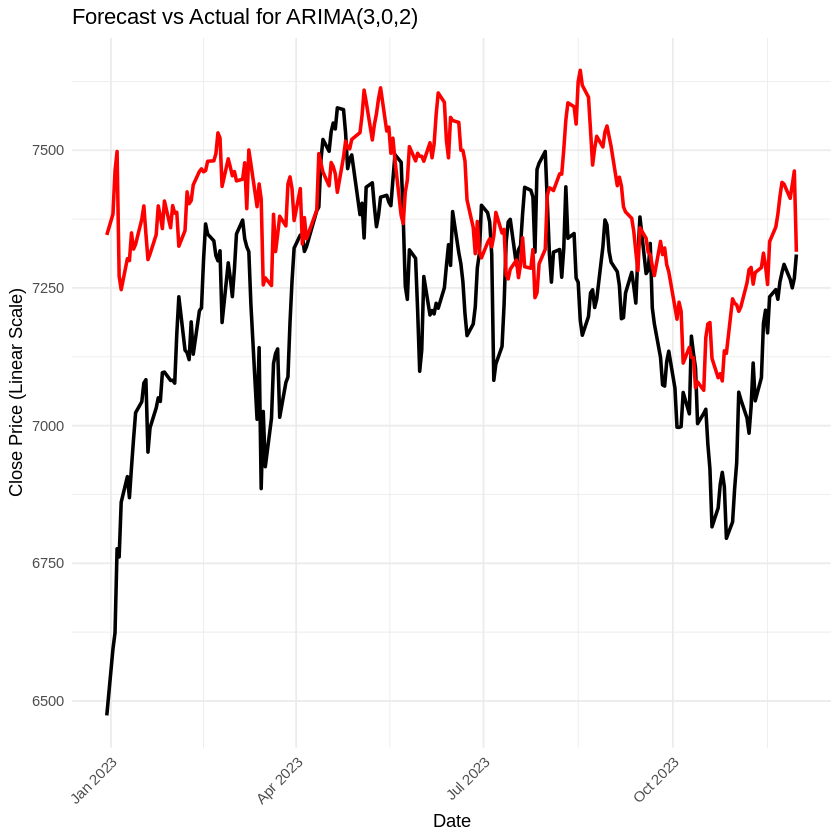

In [ ]:
# Plot for ARIMA(3,0,2) with solid lines
ggplot(df_arima_3_0_2, aes(x = Date)) +
  geom_line(aes(y = Actual), color = "black", size = 1) +
  geom_line(aes(y = Forecast), color = "red", size = 1) +  # Solid line
  ggtitle("Forecast vs Actual for ARIMA(3,0,2)") +
  xlab("Date") + ylab("Close Price (Linear Scale)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### 8.2.3.2 Prévisions ARIMA(2,0,0)

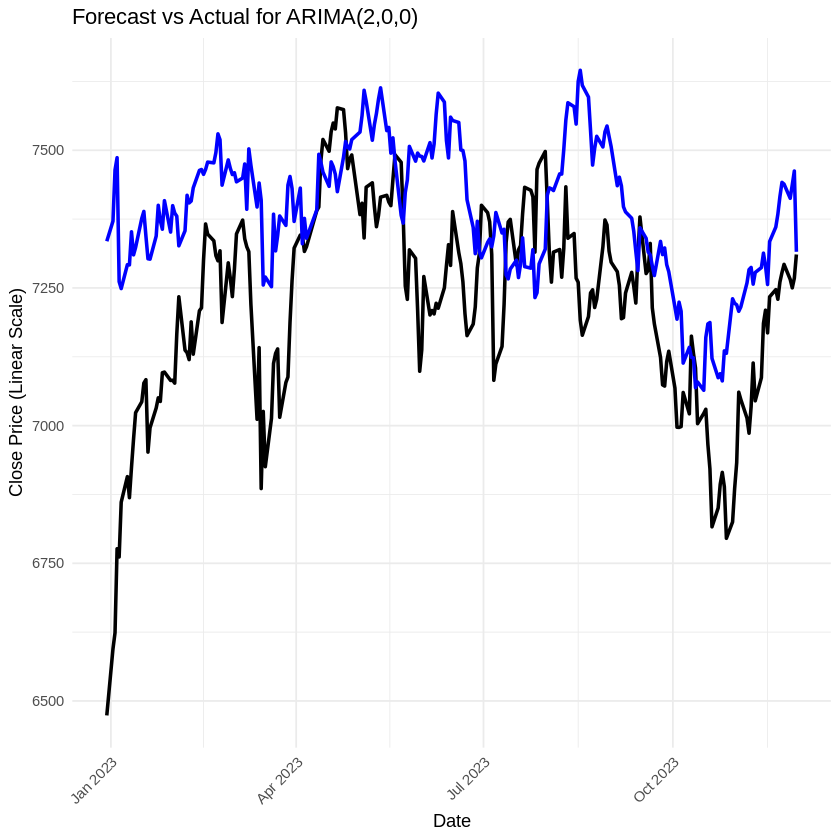

In [ ]:
# Plot for ARIMA(2,0,0) with solid lines
ggplot(df_arima_2_0_0, aes(x = Date)) +
  geom_line(aes(y = Actual), color = "black", size = 1) +
  geom_line(aes(y = Forecast), color = "blue", size = 1) +  # Solid line
  ggtitle("Forecast vs Actual for ARIMA(2,0,0)") +
  xlab("Date") + ylab("Close Price (Linear Scale)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### 8.2.3.3 Prévisions ARIMA(0,1,0)

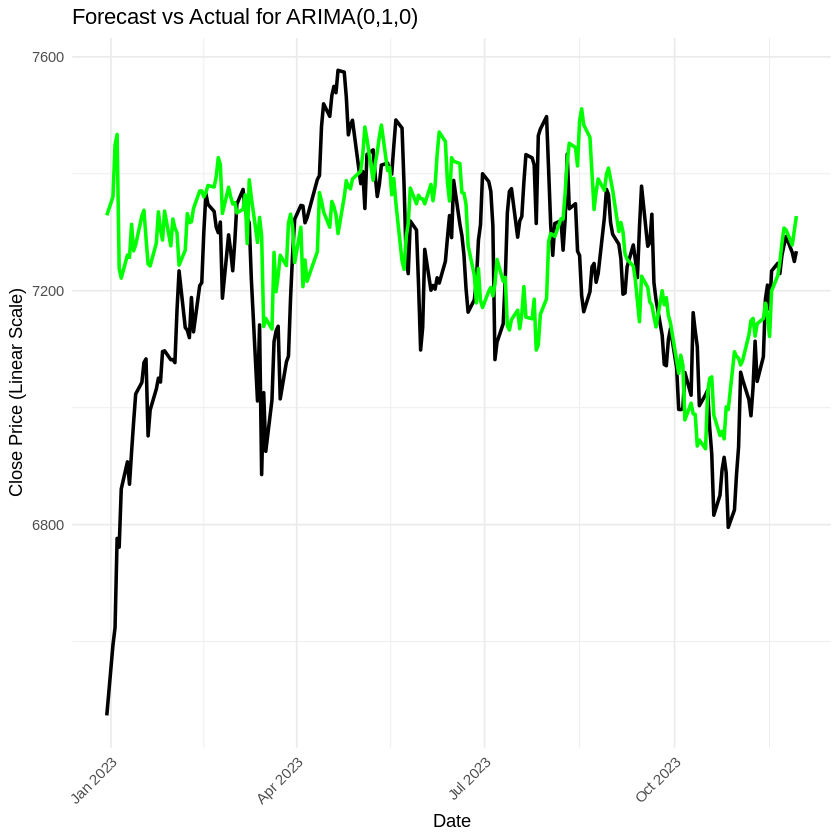

In [ ]:
# Plot for ARIMA(0,1,0) with solid lines
ggplot(df_arima_0_1_0, aes(x = Date)) +
  geom_line(aes(y = Actual), color = "black", size = 1) +
  geom_line(aes(y = Forecast), color = "green", size = 1) +  # Solid line
  ggtitle("Forecast vs Actual for ARIMA(0,1,0)") +
  xlab("Date") + ylab("Close Price (Linear Scale)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## 8.2.4 Compil et affichage des métriques de précision
- **accuracy_metrics :** Un tableau (data frame) est créé pour regrouper les résultats des métriques de précision (MAE, MSE, RMSE) pour chaque modèle ARIMA.
- **Affichage des résultats :** Les résultats sont affichés avec la fonction **cat()** et **print()** pour montrer un résumé de la performance de chaque modèle.

In [ ]:
# Compile and display accuracy metrics
accuracy_metrics <- data.frame(
  Model = c("ARIMA(3,0,2)", "ARIMA(2,0,0)", "ARIMA(0,1,0)"),
  MAE = c(results_arima_3_0_2$MAE, results_arima_2_0_0$MAE, results_arima_0_1_0$MAE),
  MSE = c(results_arima_3_0_2$MSE, results_arima_2_0_0$MSE, results_arima_0_1_0$MSE),
  RMSE = c(results_arima_3_0_2$RMSE, results_arima_2_0_0$RMSE, results_arima_0_1_0$RMSE)
)

cat("\nComparison of Forecast Accuracy Metrics:\n")
print(accuracy_metrics)


Comparison of Forecast Accuracy Metrics:
         Model      MAE      MSE     RMSE
1 ARIMA(3,0,2) 198.4947 57802.78 240.4221
2 ARIMA(2,0,0) 197.8813 57282.49 239.3376
3 ARIMA(0,1,0) 138.8663 35127.31 187.4228
